## Data Exploration

In [1]:
# Importing important libraries
import numpy as np
import pandas as pd
from IPython.display import display
%matplotlib inline

df = pd.read_csv('breast-cancer-wisconsin.data.txt') 

display(df.head())

,id,clump_thickness,unif_cell_size,unif_cell_shape,marg_adhesion,single_epith_cell_size,bare_nuclei,bland_chrom,norm_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [2]:
display(df.describe())

,id,clump_thickness,unif_cell_size,unif_cell_shape,marg_adhesion,single_epith_cell_size,bland_chrom,norm_nucleoli,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


## Data Preparation

In [3]:
df.replace('?', -999999, inplace=True) # replacing the invalid records with dummy value that will be scaled after then
df.drop(['id'], 1, inplace=True) # Droping the id column as it will affect the results and it has no importance here

X = df.drop(['class'], 1)
Y = df['class']

all_records = df.shape[0]
benign_records = df[df['class'] == 2].shape[0]
maligant_records = df[df['class'] == 4].shape[0]

print("We have {} records".format(all_records))
print("We have {} maligant records".format(maligant_records))
print("We have {} benign records".format(benign_records))
print("The maligant perentage is {:.2f} %".format(maligant_records / all_records * 100))
print("The benign perentage is {:.2f} %".format(benign_records / all_records * 100))

We have 699 records
We have 241 maligant records
We have 458 benign records
The maligant perentage is 34.48 %
The benign perentage is 65.52 %


## Data visualization

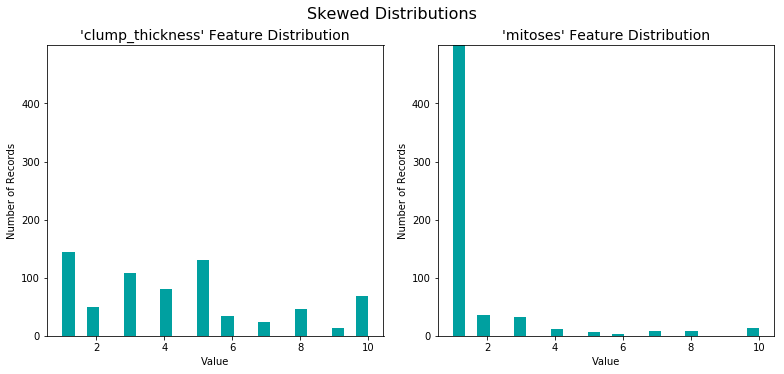

In [4]:
import visuals as vs

vs.distribution(df) # visualizing columns to search for skewed data.

## Shuffle and split data

In [5]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=7)    

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 559 samples.
Testing set has 140 samples.


## Feature scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler() # scale our data to make it robust to our model
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Model Selection

In [7]:
# Here we try some of the algorithms that i think is the most powerful candidates to our problem
from sklearn.svm import SVC
from sklearn.ensemble  import GradientBoostingClassifier

clf_A = SVC(kernel = 'linear', random_state = 5)
clf_B = GradientBoostingClassifier(random_state=70)

clf_A.fit(X_train, y_train)
clf_B.fit(X_train, y_train)

y_pred_A = clf_A.predict(X_test)
y_pred_B = clf_B.predict(X_test)

### Models evaluation 

In [8]:
# Here we print the results of each one

from sklearn.metrics import fbeta_score

A_fbeta_score = fbeta_score(y_test, y_pred_A, beta=0.7, pos_label=2)

B_fbeta_score = fbeta_score(y_test, y_pred_B, beta=0.7, pos_label=2)

print ("svm fbeta score ", A_fbeta_score*100)
print("----------------------------------------------------")
print ("Gradient Boosting fbeta score ",B_fbeta_score * 100)

svm fbeta score  95.99531444468849
----------------------------------------------------
Gradient Boosting fbeta score  96.70329670329672


## Choosing the best model

Best value for n_estimator parameter is 100
Best value for learning_rate parameter is 1

 Unoptimized model
------
Fbeta-score on testing data: 0.9670

Optimized Model
------
Final Fbeta-score on the testing data: 0.9600
Normalized confusion matrix
[[0.96703297 0.03296703]
 [0.08163265 0.91836735]]


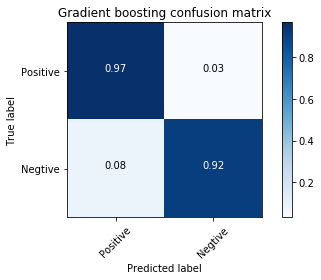

In [9]:
#Here i have chossen gradient boosting as the best algorithm and i use grid search to return the best estimator

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, r2_score, fbeta_score
from sklearn.model_selection import ShuffleSplit

clf = GradientBoostingClassifier(random_state=42) # Initialize the classifer

parameters = {'n_estimators': [100, 200, 400],
              'learning_rate': [0.01, 0.1, 1, 1.5]
             } # Choosing the set of parameters

cv_sets = ShuffleSplit(n_splits=10,test_size=0.2) # define the cross validation function
scorer = make_scorer(fbeta_score, beta=0.7, pos_label=2) # Define the scorer function 
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=cv_sets) # Initilize the grid object
grid_fit = grid_obj.fit(X_train, y_train) # train the grid object
best_clf = grid_fit.best_estimator_  # Obtaining the best classifier

best_clf.fit(X_train, y_train) # Training the new (best)classifier
best_predictions = best_clf.predict(X_test) # Predicting resulsts 

print("Best value for n_estimator parameter is", best_clf.get_params()['n_estimators'])
print("Best value for learning_rate parameter is", best_clf.get_params()['learning_rate'])

print ("\n Unoptimized model\n------")
print ("Fbeta-score on testing data: {:.4f}".format(B_fbeta_score))
print ("\nOptimized Model\n------")
print ("Final Fbeta-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.7, pos_label=2)))

my_conf_matrix = confusion_matrix(y_test, best_predictions) # Calculating the confussion matrix
vs.plot_confusion_matrix(my_conf_matrix, classes=['Positive', 'Negtive'], normalize=True, title="Gradient boosting confusion matrix")

In [10]:
# Here i'm defining a function for you to ease the testing process for you, 
# all you have to do is to provide the feature array in the next code cell
def predict_cancer(clf, arr):
    results = clf.predict(arr.reshape(1, -1))
    
    return results

## Predicting results

In [11]:
my_arr = np.array([9,5,5,4,4,5,4,3,3]) # <=== pass the features array here

result = predict_cancer(best_clf, my_arr) # Invoking the predicting funcrion

if result == 2:
    print("The tumor is benign")
elif result == 4:
    print("The tumor is malignant")

The tumor is malignant
